In [36]:
from collections import defaultdict

import gseapy as gp
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 200)

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scripts import aesthetics

aesthetics.activate_paper_rcParams()

In [37]:
import palettable

Bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

# Analyze Gene Set Enrichment Results

My previous notebook, where I generated the results for the gene set enrichment results (`cwas-gene-set-enrichment`), was getting way too long. I'll use this notebook to analyze the results instead.

There are a _ton_ of results here. We'll need to be careful in parsing through these.

# Load in our data

We have to load in all our appropriate data, including SVs and the gene set enrichment results. We copy the same process as detailed in `cwas-gene-set-enrichment`

In [38]:
# define SVs and dosages for discovery and validation
sv_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

In [39]:
intergenic_sv_to_gene_distances = pd.read_csv('data/cwas-results/intergenic-sv-to-gene-distances.csv')

Load metadata and SVs

In [40]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
samples = defaultdict(dict)
total_samples = []
for disease in ["neuroblastoma", "ewing"]:
    for cohort in ["case", "control"]:
        
        disease_cohort_samples = metadata[(metadata[f"{disease}_{cohort}"] == True)][
            "entity:sample_id"
        ].tolist()
        
        samples[disease][cohort] = disease_cohort_samples
        print(disease, cohort, len(samples[disease][cohort]))
        
        total_samples += disease_cohort_samples
        
total_samples = sorted(set(total_samples))

neuroblastoma case 688
neuroblastoma control 4831
ewing case 775
ewing control 4574


We don't need the SVs for now, but leaving this in for future reference.

In [41]:
# ###############
# ##### SVs #####
# ###############
# svs = pd.read_csv(sv_path, sep="\t", usecols=range(49))

# ###############
# ### Dosages ###
# ###############=

# # we only need the dosages of our samples in question
# dosage_head = pd.read_csv(dosages_path, sep="\t", index_col=False, nrows=1)

# cols = [3] + [i for i, c in enumerate(dosage_head.columns) if c in total_samples]

# dosages = pd.read_csv(dosages_path, sep="\t", index_col=False, usecols=cols)

# dosages = dosages.set_index("ID")

## Read in category genes

These are the genes that are eligible for each category.

In [42]:
# category_gene_matrix = pd.read_csv(
#     "data/cwas-results/category-gene-matrix.csv"
# ).set_index("category")

In [43]:
# category_gene_matrix.iloc[:10, :50]

In [44]:
# gene_ref = list(category_gene_matrix.columns)

## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files. Focusing on neuroblastoma.

In [45]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding


In [46]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

We add a metric for whether the category is significant after bonferroni, based on a message for Riaz giving us a cutoff

In [47]:
num_tests = {
    "neuroblastoma-coding": 279,
    "neuroblastoma-noncoding": 940,
    "ewing-coding": 267,
    "ewing-noncoding": 916,
}

In [48]:
framework_results["bonferroni_p"] = framework_results.apply(
    lambda row: row["p_value"] * num_tests[row["disease"] + "-" + row["sv_category"]],
    axis=1,
)

framework_results["bonferroni_significant"] = framework_results["bonferroni_p"] < 0.05

In [49]:
framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,disease,sv_category,af_category,bonferroni_p,bonferroni_significant
0,0.175033,0.771178,0.226968,0.820448,2,1,644,646,12,1,4687,4699,20,DEL.SINGLETON.ANY.missense_constrained.ANY.signaling_transduction_by_receptor_tyrosine_kinases_genes,DEL,SINGLETON,0.003096,0.002554,0.002619,0.085949,neuroblastoma,coding,singleton,228.905063,False
1,0.245302,0.150614,1.628679,0.103381,53,1,593,646,309,2,4403,4699,479,DEL.SINGLETON.ANY.unconstrained.expressed_in_adrenal_gland.protein_coding,DEL,SINGLETON,0.082043,0.065759,0.067727,0.985559,neuroblastoma,coding,singleton,28.843295,False


In [50]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):
    if "osteosarcoma" in file:
        continue

    disease = "neuroblastoma" if "neuroblastoma" in file else "ewing"
    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

## Shrink down our data

We subset some of our data to prevent working with massive matrices.

In [53]:
# # shrink down our categories to only those that are significant
# framework_results = framework_results.query("negative_log10_p_value > 3.0").reset_index(
#     drop=True
# )

# # subset our SVs to these categories. Have to be careful about disease, since category names can repeat.
# included_disease_categories = (framework_results['disease'] + '-' + framework_results['category_name']).tolist()

# # subset down category svs to these categories
# category_svs = category_svs[(category_svs['disease'] + '-' + category_svs['category']).isin(included_disease_categories)].reset_index(drop = True)

# # drop SVs down to these SVs
# svs = svs[svs['name'].isin(set(category_svs['SV']))]

# # shrink dosages down to our nbl samples and these SVs
# full_sample_list = samples['ewing']['case'] + samples['ewing']['control'] + samples['neuroblastoma']['case'] + samples['neuroblastoma']['control']
# dosages = dosages.loc[svs['name'].tolist(), sorted(set(full_sample_list))]

# # shrink down category lookups
# category_gene_matrix = category_gene_matrix.loc[sorted(set(framework_results['category_name']))]

## Read in gene set enrichment results

Read in our GSE results for the categories. This file is _huge_, since we fully enumerated a number of possible analyses.

In [54]:
ref_counts = pd.read_csv("data/cwas-results/reference-counts.csv")

In [55]:
gse_results = pd.read_csv(
    "data/cwas-results/cwas-gene-set-enrichment-results.csv"
)
binom_results = pd.read_csv("data/cwas-results/cwas-category-gs-binomial-results.csv")

# subset data
gse_results = gse_results[
    gse_results["category"].isin(framework_results["category_name"].tolist())
]
binom_results = binom_results[
    binom_results["category"].isin(framework_results["category_name"].tolist())
]

# reformat and merge
overlap_cols = ["disease", "category", "sv_category", "db", "gs"]
gse_results.columns = [
    c + "_fisher" if c not in overlap_cols else c for c in gse_results.columns
]
binom_results.columns = [
    c + "_binom" if c not in overlap_cols else c for c in binom_results.columns
]

combined_gse_results = gse_results.merge(binom_results, on=overlap_cols)

In [56]:
# also read in the baseline category results
baseline_gse_results = pd.read_csv(
    "data/cwas-results/category-gene-set-raw-significance.csv"
)[["category", "db", "gs", "expected", "data", "odds_ratio", "p", "fdr_p"]]
baseline_gse_results = baseline_gse_results.drop_duplicates(
    subset=["category", "db", "gs"]
)

# merge again
overlap_cols = ["category", "db", "gs"]
baseline_gse_results.columns = [
    c + "_cat_baseline" if c not in overlap_cols else c
    for c in baseline_gse_results.columns
]
combined_gse_results = combined_gse_results.merge(baseline_gse_results, on=overlap_cols, how = 'left')

In [63]:
combined_gse_results = combined_gse_results[
    (combined_gse_results["db"] == "GO_Biological_Process_Full")
]

We also add a column for the number of genes that show up as a hit in baseline enrichment for cases

In [64]:
combined_gse_results.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline
50,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,regulation of protein secretion (GO:0050708),32/3833,0/113,0,1.010633,1.0,1.0,2261.0,294/25805,7/632,6,1.105193,1.00000,1.000000,2261.00000,4/568,0/54,0,2.054545,1.0,1.0,2261.0,0.009483,0.0,0.631394,1.0,1427.58232,0,0.009483,0.011076,0.677287,1.0,1531.345367,6,0.009483,0.0,1.0,1.0,2261.0,0,259/19092,46/4851,0.630493,0.003958,0.036706
51,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,negative regulation of fibroblast proliferation (GO:0048147),2/3833,0/113,0,11.204678,1.0,1.0,2261.0,8/25805,2/632,2,13.628104,0.02261,0.223043,51.12119,2/568,0/54,0,3.436364,1.0,1.0,2261.0,0.001443,0.0,1.000000,1.0,2261.00000,0,0.001443,0.003165,0.231880,1.0,524.279723,2,0.001443,0.0,1.0,1.0,2261.0,0,34/19092,7/4851,0.760758,0.693309,1.000000


In [65]:
rename = {
    "category_name": "category",
    "bonferroni_significant": "category_bonferroni_significant",
}
merge = framework_results[
    ["point_estimate", "category_name", "disease", "bonferroni_significant"]
].rename(columns=rename)

In [66]:
combined_gse_results = combined_gse_results.merge(merge, on=["disease", "category"])

So now we have all our data. It's very complicated.

In [67]:
category_to_expression = {
    c: c.split(".")[4] if len(c.split(".")) == 6 else c.split(".")[6]
    for c in framework_results["category_name"].tolist()
}
category_to_functional = {
    c: c.split(".")[3] if len(c.split(".")) == 8 else np.nan
    for c in framework_results["category_name"].tolist()
}

combined_gse_results["expression"] = [
    category_to_expression[c] for c in combined_gse_results["category"]
]
combined_gse_results["functional_category"] = [
    category_to_functional[c] for c in combined_gse_results["category"]
]

Now we read in the gene sets

In [68]:
gene_sets = {}
with open("ref/gene-sets.txt") as gs_in:
    for line in gs_in:
        comp = line.strip().split("\t")
        db = comp[0]
        gs = comp[1]
        genes = comp[2:]

        if db in ["Reactome_2022", "GO_Biological_Process_Specific", "custom", "MSigDB_Hallmark_2020"]:
            continue

        if len(genes) >= 30 and len(genes) <= 1000:
            gene_sets[db + " | " + gs] = genes

In [69]:
replace_dict = {' - ': ' ', ' ': '-', '(': '', ')': ''}
with open('data/gtex-tissue-specific-gene-sets.txt') as out:
    for line in out.readlines():
        line = line.strip()
        tissue = line.split(' | ')[0].lower()
        genes = line.split(' | ')[1].split(',')
    
        for char, char_map in replace_dict.items():
            tissue = tissue.lower().replace(char, char_map)
        
        gene_sets[f'gtex | {tissue}'] = genes

In [70]:
len(gene_sets)

3043

In [71]:
num_effective_tests = 2316

# Analyze high level category results

To start, we'll examine the category baseline results alone.

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


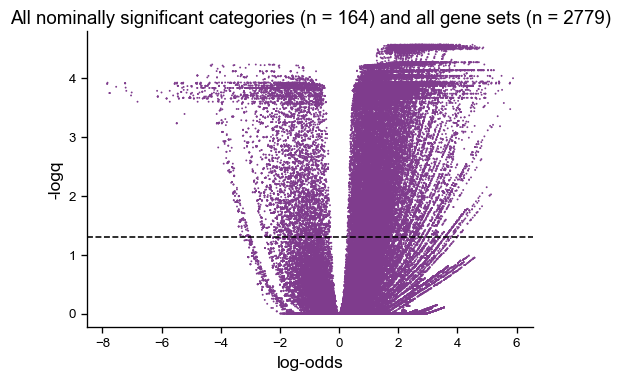

In [155]:
fig, ax = plt.subplots(1, figsize=(6, 4))
sns.scatterplot(
    x=np.log2(combined_gse_results["odds_ratio_cat_baseline"][::2]),
    y=-np.log10(combined_gse_results["fdr_p_cat_baseline"][::2]),
    ec=None,
    s=2,
)
sns.despine(ax=ax)
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black")
ax.set_xlabel("log-odds")
ax.set_ylabel("-logq")
ax.set_title(
   f"All nominally significant categories (n = 164) and all gene sets (n = {len(gene_sets)})"
)
fig.savefig("images/baseline-category-enrichment-all.png", bbox_inches="tight")

## Compare the binary genes vs. full counts

We used two approaches--one that binarized genes impacted by SVs and another that actually used counts. I want to compare these two.

In [156]:
binary = combined_gse_results.iloc[::2, :]
full = combined_gse_results.iloc[1::2, :]

In [157]:
binary.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,regulation of protein secretion (GO:0050708),32/3833,0/113,0,1.010633,1.0,1.0,2316.0,294/25805,7/632,6,1.105193,1.000000,1.0,2316.000000,4/568,0/54,0,2.054545,1.0,1.0,2316.0,0.009483,0.0,0.631394,1.0,1462.309002,0,0.009483,0.011076,0.677287,1.0,1568.596139,6,0.009483,0.0,1.0,1.0,2316.0,0,259/19092,46/4851,0.630493,0.003958,0.036706,0.332482,False,ANY,NaN
2,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,neuron apoptotic process (GO:0051402),7/3833,0/113,0,4.196272,1.0,1.0,2316.0,44/25805,0/632,0,0.904406,0.628085,1.0,1454.645021,2/568,0/54,0,3.436364,1.0,1.0,2316.0,0.001031,0.0,1.000000,1.0,2316.000000,0,0.001031,0.000000,1.000000,1.0,2316.000000,0,0.001031,0.0,1.0,1.0,2316.0,0,103/19092,5/4851,0.148903,0.000002,0.000146,0.332482,False,ANY,NaN


We care about cases, so let's see what happens to the odds-ratios usually

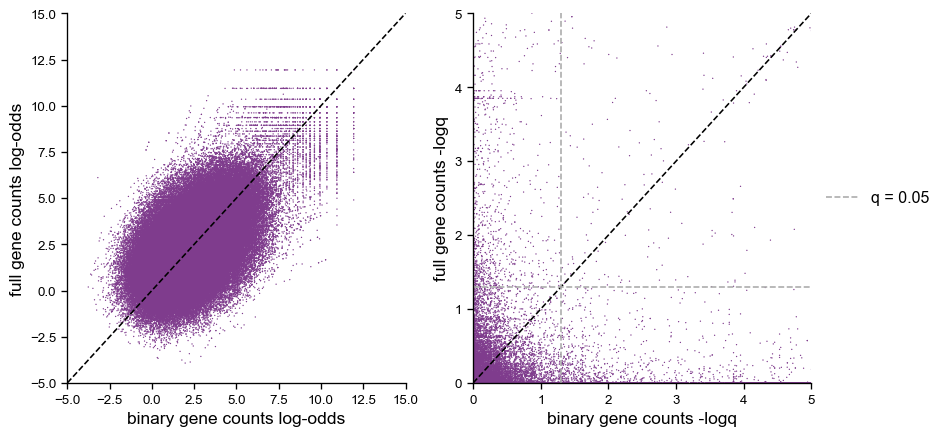

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, col in enumerate(["odds_ratio_cases_fisher", "fdr_p_cases_fisher"]):

    ax = axes[i]

    data_binary = binary[col].values
    data_full = full[col].values

    if col == "odds_ratio_cases_fisher":
        data_binary = np.log2(data_binary)
        data_full = np.log2(data_full)
    else:
        data_binary = -np.log10(data_binary)
        data_full = -np.log10(data_full)

    sns.scatterplot(x=data_binary, y=data_full, ec=None, s=1, ax=ax)

    lim = [-5, 15] if col == "odds_ratio_cases_fisher" else [0, 5]
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.plot(lim, lim, linestyle="dashed", color="black")

    label = ["log-odds", "-logq"][i]
    ax.set_xlabel("binary gene counts " + label)
    ax.set_ylabel("full gene counts " + label)
    sns.despine(ax=ax)

    if col == "fdr_p_cases_fisher":
        ax.axhline(
            -np.log10(0.05), color="darkgrey", linestyle="dashed", label="q = 0.05"
        )
        ax.axvline(-np.log10(0.05), color="darkgrey", linestyle="dashed")
        ax.legend(bbox_to_anchor=(1, 0.5))

fig.savefig(
    "images/binary-vs-full-gene-counts-gse-log-odds-logq.png", bbox_inches="tight"
)

So we can see that while the use of full counts doesn't have a _dramatic_ impact on odds-ratio (on average), it has a _substantial_ impact on p-value. This makes sense because full counts give more power.

I've come to the conclusion that should we use one of these, it should just be the full gene counts. But I don't think we actually care about these.

## Compare enrichment based on genomic overlap and SV counts

In [159]:
full.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,negative regulation of fibroblast proliferation (GO:0048147),2/3833,0/113,0,11.204678,1.0,1.0,2316.0,8/25805,2/632,2,13.628104,0.022610,0.216666,52.364739,2/568,0/54,0,3.436364,1.0,1.0,2316.0,0.001443,0.0,1.0,1.0,2316.0,0,0.001443,0.003165,0.231880,1.0,537.033099,2,0.001443,0.0,1.0,1.0,2316.0,0,34/19092,7/4851,0.760758,0.693309,1.000000,0.332482,False,ANY,NaN
3,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,regulation of peptide hormone secretion (GO:0090276),17/3833,0/113,0,1.860136,1.0,1.0,2316.0,170/25805,6/632,5,1.673727,0.320482,0.754890,742.237311,3/568,0/54,0,2.572727,1.0,1.0,2316.0,0.006803,0.0,1.0,1.0,2316.0,0,0.006803,0.009494,0.334123,1.0,773.829692,5,0.006803,0.0,1.0,1.0,2316.0,0,196/19092,33/4851,0.591562,0.004925,0.043618,0.332482,False,ANY,NaN


/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  


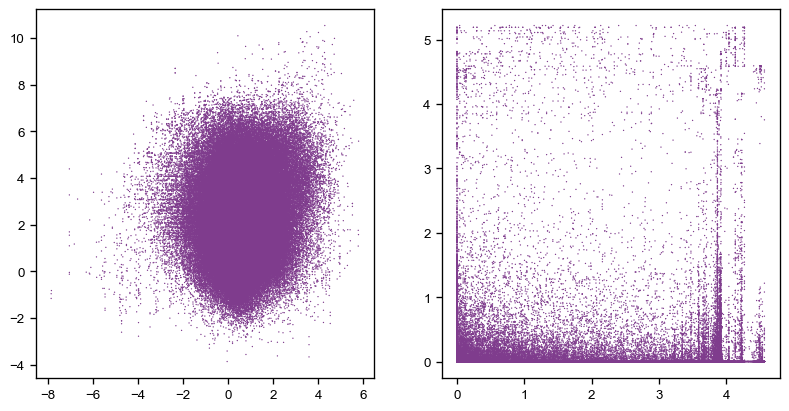

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, (count_col, overlap_col) in enumerate(
    [
        ["odds_ratio_cases_fisher", "odds_ratio_cat_baseline"],
        ["fdr_p_cases_fisher", "fdr_p_cat_baseline"],
    ]
):

    ax = axes[i]

    data_overlap = full[overlap_col].values
    data_full = full[count_col].values

    if count_col == "odds_ratio_cases_fisher":
        data_overlap = np.log2(data_overlap)
        data_full = np.log2(data_full)
    else:
        data_overlap = -np.log10(data_overlap)
        data_full = -np.log10(data_full)

    sns.scatterplot(x=data_overlap, y=data_full, ec=None, s=1, ax=ax)

## Examine category baseline vs. binomial test

This is what I think we _actually_ care about.

In [161]:
combined_gse_results.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,regulation of protein secretion (GO:0050708),32/3833,0/113,0,1.010633,1.0,1.0,2316.0,294/25805,7/632,6,1.105193,1.00000,1.000000,2316.000000,4/568,0/54,0,2.054545,1.0,1.0,2316.0,0.009483,0.0,0.631394,1.0,1462.309002,0,0.009483,0.011076,0.677287,1.0,1568.596139,6,0.009483,0.0,1.0,1.0,2316.0,0,259/19092,46/4851,0.630493,0.003958,0.036706,0.332482,False,ANY,NaN
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,negative regulation of fibroblast proliferation (GO:0048147),2/3833,0/113,0,11.204678,1.0,1.0,2316.0,8/25805,2/632,2,13.628104,0.02261,0.216666,52.364739,2/568,0/54,0,3.436364,1.0,1.0,2316.0,0.001443,0.0,1.000000,1.0,2316.000000,0,0.001443,0.003165,0.231880,1.0,537.033099,2,0.001443,0.0,1.0,1.0,2316.0,0,34/19092,7/4851,0.760758,0.693309,1.000000,0.332482,False,ANY,NaN


In [162]:
combined_gse_results_full = combined_gse_results[
    combined_gse_results["analysis_fisher"] == "full"
]

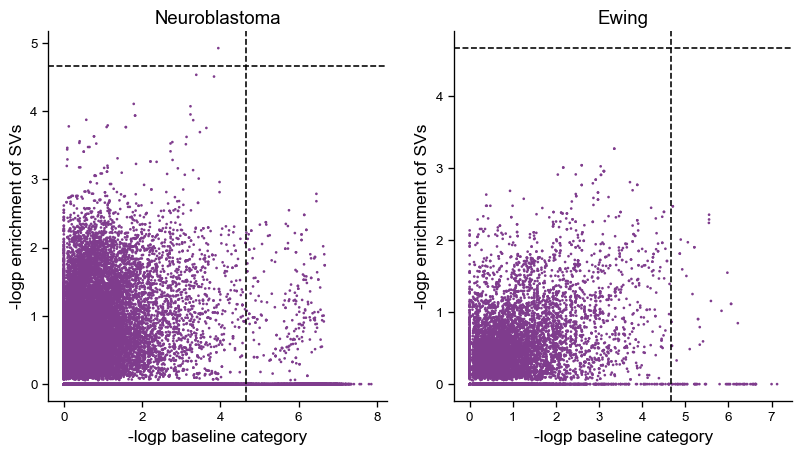

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, disease in enumerate(["neuroblastoma", "ewing"]):

    ax = axes[i]

    sns.scatterplot(
        x=-np.log10(
            combined_gse_results_full.query(f'disease == "{disease}"')["p_cases_fisher"]
        ),
        y=-np.log10(
            combined_gse_results_full.query(f'disease == "{disease}"')[
                "p_cases_unique_binom"
            ]
        ),
        ec=None,
        s=4,
        ax=ax,
    )

    sns.despine(ax=ax)
    ax.axhline(
        y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="black"
    )
    ax.axvline(
        x=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="black"
    )
    ax.set_xlabel("-logp baseline category")
    ax.set_ylabel("-logp enrichment of SVs")
    ax.set_title(disease.capitalize())
    # fig.savefig("images/baseline-category-enrichment-all.png", bbox_inches="tight")

# Analyze most stringent results

We apply a handful of filters:

* Single gene SVs
* Remove genes in controls for within-category (don’t do this in baseline, because control signal already controlled by examining nominal cats)
* p_controls_binomial > 0.05 (no within-category control enrichment)
* At least two genes affected (for within and baseline)

In [164]:
# filter out signals in control, ensure a minimum gene overlap, and use the full fishers test
stringent_results = combined_gse_results.query(
    "p_controls_binom > 0.05 & analysis_fisher == 'full'"
)

In [165]:
stringent_results.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,regulation of protein secretion (GO:0050708),32/3833,0/113,0,1.010633,1.0,1.0,2316.0,294/25805,7/632,6,1.105193,1.00000,1.000000,2316.000000,4/568,0/54,0,2.054545,1.0,1.0,2316.0,0.009483,0.0,0.631394,1.0,1462.309002,0,0.009483,0.011076,0.677287,1.0,1568.596139,6,0.009483,0.0,1.0,1.0,2316.0,0,259/19092,46/4851,0.630493,0.003958,0.036706,0.332482,False,ANY,NaN
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,negative regulation of fibroblast proliferation (GO:0048147),2/3833,0/113,0,11.204678,1.0,1.0,2316.0,8/25805,2/632,2,13.628104,0.02261,0.216666,52.364739,2/568,0/54,0,3.436364,1.0,1.0,2316.0,0.001443,0.0,1.000000,1.0,2316.000000,0,0.001443,0.003165,0.231880,1.0,537.033099,2,0.001443,0.0,1.0,1.0,2316.0,0,34/19092,7/4851,0.760758,0.693309,1.000000,0.332482,False,ANY,NaN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


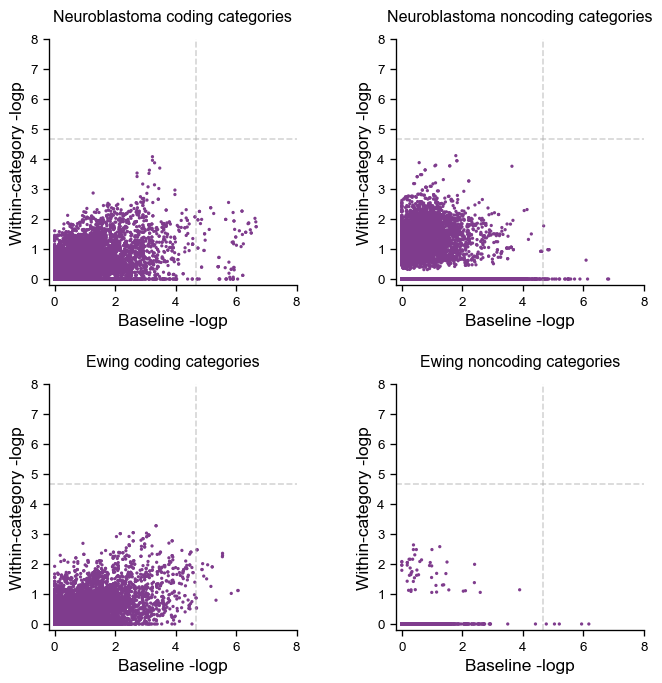

In [166]:
fig, axes = plt.subplots(
    2, 2, figsize=(8, 8), gridspec_kw={"hspace": 0.4, "wspace": 0.4}
)
for i, disease in enumerate(["neuroblastoma", "ewing"]):
    for j, sv_category in enumerate(["coding", "noncoding"]):

        ax = axes[i, j]

        data = stringent_results[
            (stringent_results["disease"] == disease)
            & (stringent_results["sv_category"] == sv_category)
        ].copy()

        data["x"] = -np.log10(data["p_cases_fisher"])
        data["y"] = -np.log10(data["p_cases_unique_binom"])

        data = data.dropna(subset=["x", "y"])

        sns.scatterplot(x = 'x', y = 'y', data = data, 
                        ax = ax, s = 6, ec=None)
        
        ax.legend().remove()

        ax.set_xlim([-0.2, 8])
        ax.set_ylim([-0.2, 8])
        ax.set_xlabel("Baseline -logp")
        ax.set_ylabel("Within-category -logp")
        ax.axvline(
            x=-np.log10(0.05 / num_effective_tests),
            color="darkgrey",
            linestyle="dashed",
            alpha=0.5,
        )
        ax.axhline(
            y=-np.log10(0.05 / num_effective_tests),
            color="darkgrey",
            linestyle="dashed",
            alpha=0.5,
        )
        ax.set_title(
            disease.capitalize() + f" {sv_category} categories", fontsize=12, y=1.04
        )

        sns.despine()

fig.savefig(
    f"images/separating-influences-cwas-gene-set-enrichment-coding.png",
    bbox_inches="tight",
)

# Dig into these results

## Neuroblastoma coding

### Within category enrichment

In [167]:
nbl_coding = combined_gse_results.query(
    'disease == "neuroblastoma" & sv_category == "coding" & analysis_fisher == "full"'
)
nbl_coding = nbl_coding.query("p_controls_binom > 0.05")

nbl_coding['hue_within'] = np.where(nbl_coding['num_unique_genes_in_overlap_cases_unique_binom'] > 1, '≥ 2', '1')
palette = {'≥ 2': Bold_10[0], '1': 'darkgrey'}

nbl_coding["binom_odds_ratio"] = (
    nbl_coding["observed_prop_cases_binom"] / nbl_coding["observed_prop_controls_binom"]
)

nbl_coding["x_within"] = np.log2(nbl_coding["binom_odds_ratio"])
nbl_coding["y_within"] = -np.log10(nbl_coding["p_cases_unique_binom"])

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


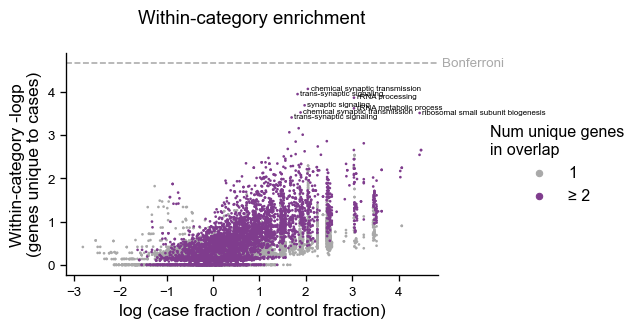

In [168]:
fig, ax = plt.subplots(1, figsize=(5, 3))

data = nbl_coding.query('num_unique_genes_in_overlap_cases_unique_binom > 0')
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_within',
        y='y_within',
        hue = 'hue_within',
        data = data[data['hue_within'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )

ax.legend(bbox_to_anchor = (1.1, 0.5), title = 'Num unique genes\nin overlap', title_fontsize = 12)
    
seen_ps = []
seen_or = []
for i, row in (
    data.sort_values(by="p_cases_unique_binom").reset_index().iterrows()
):

    x = row["x_within"]
    y = row["y_within"]

    if y in seen_ps and x in seen_or:
        continue
    else:
        s = row["gs"]
        if " (" in s:
            s = s[: s.index(" (")]

        ax.text(x=x + 0.06, y=y + 0.02, s=s, fontsize=6, ha="left", va="center")
        seen_ps.append(y)
        seen_or.append(x)

    if len(seen_ps) > 7:
        break

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
sns.despine(ax=ax)
ax.set_xlabel("log (case fraction / control fraction)")
ax.set_ylabel("Within-category -logp\n(genes unique to cases)")
ax.set_title("Within-category enrichment", y=1.1)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)

fig.savefig("images/nbl-coding-within-category.png", bbox_inches="tight")

What are the categories that have synaptic transmission signal?

In [169]:
nbl_coding.sort_values(by="fdr_p_cases_unique_binom").head(10)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within
22827,neuroblastoma,ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,rRNA processing (GO:0006364),22/3797,6/149,6,7.980676,0.000496,0.097041,1.147962,133/25621,4/816,4,1.169843,1.000000,1.000000,2316.000000,6/552,6/70,6,8.415385,0.000883,1.000000,2.044394,0.011132,0.040268,0.006773,0.379665,15.685581,6,0.011132,0.004902,0.094604,0.922474,219.103277,4,0.011132,0.085714,0.000136,0.125625,0.314086,6,212/19092,54/4851,1.003372,1.000000,1.000000,0.319513,True,ANY,NaN,≥ 2,8.214765,3.038219,3.867690
16712,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Full,chemical synaptic transmission (GO:0007268),52/3789,9/157,9,4.733443,0.000583,0.038949,1.349153,318/25573,12/864,10,1.206614,0.640098,0.810464,1482.466470,9/531,8/91,8,5.603571,0.001231,0.604172,2.851989,0.015360,0.057325,0.000786,0.288642,1.819257,9,0.015360,0.013889,0.889538,1.000000,2060.168902,10,0.015360,0.087912,0.000085,0.155369,0.196563,8,418/19092,146/9505,0.534241,0.000004,0.000125,0.311639,True,expressed_in_adrenal_gland,NaN,≥ 2,4.127389,2.045229,4.071237
16846,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Full,trans-synaptic signaling (GO:0099537),52/3789,9/157,9,4.733443,0.000583,0.038949,1.349153,321/25573,14/864,12,1.382353,0.350191,0.538944,811.042767,9/531,8/91,8,5.603571,0.001231,0.604172,2.851989,0.015992,0.057325,0.001039,0.288642,2.405520,9,0.015992,0.016204,0.891961,1.000000,2065.782115,12,0.015992,0.087912,0.000112,0.155369,0.258968,8,435/19092,152/9505,0.534289,0.000005,0.000125,0.311639,True,expressed_in_adrenal_gland,NaN,≥ 2,3.537762,1.822837,3.951493
23199,neuroblastoma,ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,rRNA metabolic process (GO:0016072),24/3797,6/149,6,7.338333,0.000734,0.119073,1.699696,138/25621,4/816,4,1.127541,1.000000,1.000000,2316.000000,8/552,6/70,6,6.521368,0.002383,1.000000,5.519019,0.012369,0.040268,0.010993,0.517781,25.459393,6,0.012369,0.004902,0.055148,0.790303,127.721982,4,0.012369,0.085714,0.000239,0.165708,0.552398,6,246/19092,60/4851,0.946331,0.768240,1.000000,0.319513,True,ANY,NaN,≥ 2,8.214765,3.038219,3.622486
24864,neuroblastoma,ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,ribosomal small subunit biogenesis (GO:0042274),8/3797,4/149,4,14.421613,0.000763,0.119073,1.766511,40/25621,1/816,1,1.529292,1.000000,1.000000,2316.000000,6/552,4/70,4,5.831557,0.018311,1.000000,42.408593,0.004535,0.02684

Let's look at what genes are actually implicated in these processes. We'll start with adipogenesis:

In [170]:
synaptic_genes = sorted(set(gene_sets["GO_Biological_Process_Full | trans-synaptic signaling (GO:0099537)"]))

test_cat_svs = category_svs[
    (category_svs["category"] == "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding")
    & (category_svs["disease"] == "neuroblastoma")
]["SV"].tolist()

case_counts = ref_counts.query(
    'disease == "neuroblastoma" & sv_category == "coding" & cohort == "case" & dose > 0'
)
res = case_counts[
    (case_counts["name"].isin(test_cat_svs)) & (case_counts["gene"].isin(synaptic_genes))
]
res

,name,dose,gene,disease,sv_category,cohort
59,PedSV.2.5.2_DEL_chr1_833,1,TPRG1L,neuroblastoma,coding,case
597,PedSV.2.5.2_DEL_chr1_9923,1,ANXA9,neuroblastoma,coding,case
1689,PedSV.2.5.2_CPX_chr3_36,1,SYN2,neuroblastoma,coding,case
3857,PedSV.2.5.2_CPX_chr7_298,1,EXOC4,neuroblastoma,coding,case
3883,PedSV.2.5.2_CPX_chr7_314,1,BRAF,neuroblastoma,coding,case
5199,PedSV.2.5.2_DEL_chr11_520,1,TH,neuroblastoma,coding,case
5303,PedSV.2.5.2_DEL_chr11_1031,1,RIC3,neuroblastoma,coding,case
5541,PedSV.2.5.2_DEL_chr11_5861,1,FCHSD2,neuroblastoma,coding,case
6087,PedSV.2.5.2_CPX_chr12_199,1,P2RX4,neuroblastoma,coding,case
6746,PedSV.2.5.2_DEL_chr15_945,1,GJD2,neuroblastoma,coding,case


In [171]:
for index, row in res.iterrows():
    print(row["gene"], end=", ")

TPRG1L, ANXA9, SYN2, EXOC4, BRAF, TH, RIC3, FCHSD2, P2RX4, GJD2, TRPV1, SYNJ1, LARGE1, 

In [172]:
synaptic_signaling_gs = [
    "GO_Biological_Process_Full | trans-synaptic signaling (GO:0099537)",
    "GO_Biological_Process_Full | chemical synaptic transmission (GO:0007268)",
    "GO_Biological_Process_Full | synaptic signaling (GO:0099536)",
]

synaptic_signaling_genes = sorted(
    set([g for gs in synaptic_signaling_gs for g in gene_sets[gs]])
)

test_cat_svs = category_svs[
    (
        category_svs["category"]
        == "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding"
    )
    & (category_svs["disease"] == "neuroblastoma")
]["SV"].tolist()

case_counts = ref_counts.query(
    'disease == "neuroblastoma" & sv_category == "coding" & cohort == "case_unique" & dose > 0'
)
res = case_counts[
    (case_counts["name"].isin(test_cat_svs))
    & (case_counts["gene"].isin(synaptic_signaling_genes))
]
res

,name,dose,gene,disease,sv_category,cohort
20680,PedSV.2.5.2_DEL_chr1_833,1,TPRG1L,neuroblastoma,coding,case_unique
20759,PedSV.2.5.2_DEL_chr1_9923,1,ANXA9,neuroblastoma,coding,case_unique
20951,PedSV.2.5.2_CPX_chr3_36,1,SYN2,neuroblastoma,coding,case_unique
21320,PedSV.2.5.2_CPX_chr7_314,1,BRAF,neuroblastoma,coding,case_unique
21543,PedSV.2.5.2_DEL_chr11_520,1,TH,neuroblastoma,coding,case_unique
21556,PedSV.2.5.2_DEL_chr11_1031,1,RIC3,neuroblastoma,coding,case_unique
21604,PedSV.2.5.2_DEL_chr11_5861,1,FCHSD2,neuroblastoma,coding,case_unique
21683,PedSV.2.5.2_CPX_chr12_199,1,P2RX4,neuroblastoma,coding,case_unique
22158,PedSV.2.5.2_INS_chr21_813,1,SYNJ1,neuroblastoma,coding,case_unique
22183,PedSV.2.5.2_DEL_chr22_1874,1,LARGE1,neuroblastoma,coding,case_unique


And what about baseline category enrichment?

### Baseline enrichment

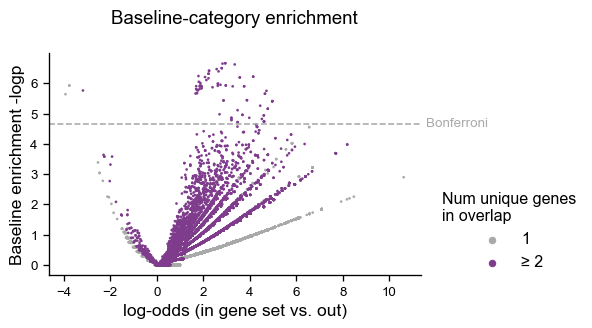

In [173]:
fig, ax = plt.subplots(1, figsize=(5, 3))

nbl_coding["x_baseline"] = np.log2(nbl_coding["odds_ratio_cases_fisher"])
nbl_coding["y_baseline"] = -np.log10(nbl_coding["p_cases_fisher"])
nbl_coding['hue_baseline'] = np.where(nbl_coding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = nbl_coding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
ax.legend(bbox_to_anchor = (1.02, 0.2), title = 'Num unique genes\nin overlap', title_fontsize = 12)

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/nbl-coding-baseline-category.png", bbox_inches="tight")

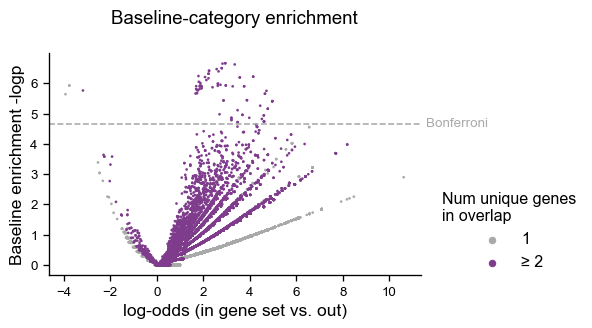

In [182]:
fig, ax = plt.subplots(1, figsize=(5, 3))

nbl_coding["x_baseline"] = np.log2(nbl_coding["odds_ratio_cases_fisher"])
nbl_coding["y_baseline"] = -np.log10(nbl_coding["p_cases_fisher"])
nbl_coding['hue_baseline'] = np.where(nbl_coding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = nbl_coding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
ax.legend(bbox_to_anchor = (1.02, 0.2), title = 'Num unique genes\nin overlap', title_fontsize = 12)

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/nbl-coding-baseline-category.png", bbox_inches="tight")

In [65]:
test = nbl_coding.query("p_cases_fisher < 0.05 / 2314").drop_duplicates(
    subset=["p_cases_fisher", "odds_ratio_cases_fisher"]
).sort_values(by="p_cases_fisher")[['category', 'gs', 'p_cases_fisher', 'odds_ratio_cases_fisher']]
test['-logp'] = -np.log10(test['p_cases_fisher'])
test['log-odds'] = -np.log2(test['odds_ratio_cases_fisher'])
test.head(8)

,category,gs,p_cases_fisher,odds_ratio_cases_fisher,-logp,log-odds
7799,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,head development (GO:0060322),2.169435e-07,7.725207,6.663653,-2.949574
40499,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,head development (GO:0060322),2.229033e-07,7.110664,6.651884,-2.829984
40769,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,forebrain development (GO:0030900),2.376154e-07,10.234014,6.624125,-3.355300
13519,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,forebrain development (GO:0030900),3.155162e-07,6.947267,6.500978,-2.796445
62281,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,brain development (GO:0007420),3.388556e-07,5.966582,6.469985,-2.576905
13231,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,brain development (GO:0007420),3.841900e-07,4.760771,6.415454,-2.251195
62299,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,head development (GO:0060322),4.029267e-07,6.318221,6.394774,-2.659518
13249,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,head development (GO:0060322),4.807094e-07,4.685065,6.318117,-2.228069


In [50]:
# nbl_coding.sort_values(by = 'fdr_p_cases_unique_binom').head(20)

What genes are actually being detected with this whole brain development stuff?

In [51]:
baseline_significant = nbl_coding.query("p_cases_fisher < 0.05 / 2314").sort_values(
    by="p_cases_fisher"
)

neuro_related = [
    "GO_Biological_Process_Full | brain development (GO:0007420)",
    "GO_Biological_Process_Full | head development (GO:0060322)",
    "GO_Biological_Process_Full | forebrain development (GO:0030900)",
    "GO_Biological_Process_Full | telencephalon development (GO:0021537)",
    "GO_Biological_Process_Full | central nervous system development (GO:0007417)"
]

adipo_related = [
    "MSigDB_Hallmark_2020 | Adipogenesis"
]

neuro_related_genes = sorted(set([g for gs in neuro_related for g in gene_sets[gs]]))
adipo_related_genes = sorted(set([g for gs in adipo_related for g in gene_sets[gs]]))

I want to take a mega biased look at just look at dosages in these genes for some large categories.

In [52]:
for i, gene_group in enumerate(
    [neuro_related_genes, adipo_related_genes]
):
    test_cat = "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding"

    test_cat_svs = category_svs[
        (category_svs["category"] == test_cat)
        & (category_svs["disease"] == "neuroblastoma")
    ]["SV"].tolist()

    # get case counts
    case_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "coding" & cohort == "case" & dose > 0'
    )
    case_counts = case_counts[(case_counts["name"].isin(test_cat_svs))]

    case_dosage = case_counts["dose"].sum()
    case_neuro_dosage = case_counts[case_counts["gene"].isin(gene_group)]["dose"].sum()

    # get control coutns
    control_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "coding" & cohort == "control" & dose > 0'
    )
    control_counts = control_counts[(control_counts["name"].isin(test_cat_svs))]

    control_dosage = control_counts["dose"].sum()
    control_neuro_dosage = control_counts[control_counts["gene"].isin(gene_group)][
        "dose"
    ].sum()

    print(case_neuro_dosage, case_dosage, control_neuro_dosage, control_dosage)

23 250 61 1317
9 250 19 1317


In [53]:
cat_genes = category_gene_matrix.loc[
    "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding"
]
cat_genes = list(cat_genes[cat_genes == 1].index)
print(len(cat_genes), len(set(cat_genes) & set(neuro_related_genes)))
print(len(cat_genes), len(set(cat_genes) & set(adipo_related_genes)))

# also check the overlap between synapse and neuro genes
print(
    len(synaptic_signaling_genes),
    len(set(synaptic_signaling_genes) & set(neuro_related_genes)),
)

9505 532
9505 179
464 73


In [54]:
len(set(neuro_related_genes) & set(adipo_related_genes))

11

In [55]:
print(532 / 9505, 23 / 246, 58 / 1288)
print(179 / 9505, 7 / 157, 15 / 864)

0.055970541820094685 0.09349593495934959 0.04503105590062112
0.01883219358232509 0.044585987261146494 0.017361111111111112


In [56]:
nbl_coding.query('category == "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding" & gs == "trans-synaptic signaling (GO:0099537)"')

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within,x_baseline,y_baseline,hue_baseline
39295,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Full,trans-synaptic signaling (GO:0099537),52/3789,9/157,9,4.733443,0.000583,0.040852,1.347988,321/25573,14/864,12,1.382353,0.350191,0.536878,810.342385,9/531,8/91,8,5.603571,0.001231,0.649945,2.849526,0.015992,0.057325,0.001039,0.28833,2.403442,9,0.015992,0.016204,0.891961,1.0,2063.998193,12,0.015992,0.087912,0.000112,0.155202,0.258744,8,435/19092,152/9505,0.534289,0.000005,0.000125,0.311639,True,expressed_in_adrenal_gland,NaN,≥ 2,3.537762,1.822837,3.951493,2.24289,3.234677,≥ 2


### Make a figure

In [111]:
nbl_coding = combined_gse_results.query(
    'disease == "neuroblastoma" & sv_category == "coding" & analysis_fisher == "full"'
)
nbl_coding = nbl_coding.query("p_controls_binom > 0.05")

# nbl_coding['hue_within'] = np.where(nbl_coding['num_unique_genes_in_overlap_cases_unique_binom'] > 1, '≥ 2', '1')
# palette = {'≥ 2': Bold_10[0], '1': 'darkgrey'}

nbl_coding["x_baseline"] = np.log2(nbl_coding["odds_ratio_cases_fisher"])
nbl_coding["y_baseline"] = -np.log10(nbl_coding["p_cases_fisher"])
# nbl_coding['hue_baseline'] = np.where(nbl_coding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

Text(0.5, 1.1, 'Baseline-category enrichment')

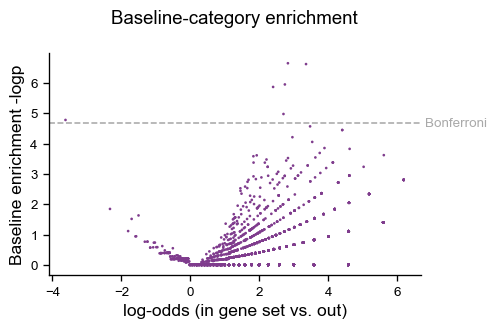

In [112]:
# pick a category
test_cat = 'ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding'

fig, ax = plt.subplots(1, figsize=(5, 3))

data = nbl_coding.query(f'category == "{test_cat}"').copy()
    
sns.scatterplot(
    x='x_baseline',
    y='y_baseline',
    data = data,
    s=4,
    ec=None,
    ax=ax
)
    
# ax.legend(bbox_to_anchor = (1.02, 0.2), title = 'Num unique genes\nin overlap', title_fontsize = 12)

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

# fig.savefig("images/nbl-coding-baseline-category.png", bbox_inches="tight")

Text(0.5, 1.1, 'Baseline-category enrichment')

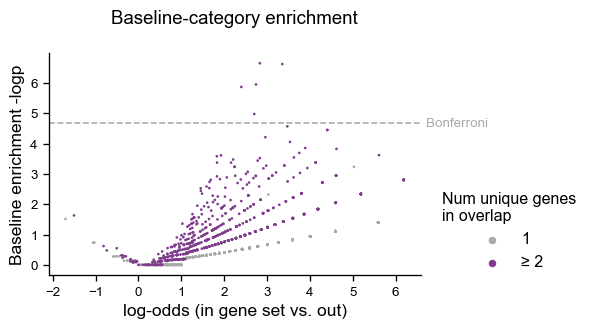

In [68]:
# pick a category
test_cat = 'ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding'

fig, ax = plt.subplots(1, figsize=(5, 3))

data = nbl_coding.query(f'category == "{test_cat}"').copy()
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
ax.legend(bbox_to_anchor = (1.02, 0.2), title = 'Num unique genes\nin overlap', title_fontsize = 12)

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

# fig.savefig("images/nbl-coding-baseline-category.png", bbox_inches="tight")

## Neuroblastoma non-coding

### Within category enrichment

In [72]:
nbl_noncoding = combined_gse_results.query(
    'disease == "neuroblastoma" & sv_category == "noncoding" & analysis_fisher == "full"'
)
nbl_noncoding = nbl_noncoding.query("p_controls_binom > 0.05")

nbl_noncoding['hue_within'] = np.where(nbl_noncoding['num_unique_genes_in_overlap_cases_unique_binom'] > 1, '≥ 2', '1')
palette = {'≥ 2': Bold_10[0], '1': 'darkgrey'}

nbl_noncoding["binom_odds_ratio"] = (
    nbl_noncoding["observed_prop_cases_binom"] / nbl_noncoding["observed_prop_controls_binom"]
)

nbl_noncoding["x_within"] = np.log2(nbl_noncoding["binom_odds_ratio"])
nbl_noncoding["y_within"] = -np.log10(nbl_noncoding["p_cases_unique_binom"])

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


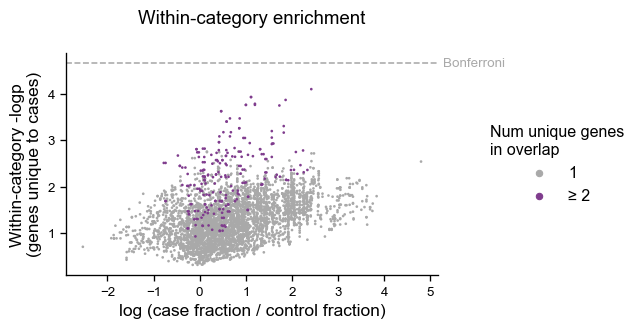

In [73]:
fig, ax = plt.subplots(1, figsize=(5, 3))

data = nbl_noncoding.query('num_unique_genes_in_overlap_cases_unique_binom > 0').copy()
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_within',
        y='y_within',
        hue = 'hue_within',
        data = data[data['hue_within'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )

ax.legend(bbox_to_anchor = (1.1, 0.5), title = 'Num unique genes\nin overlap', title_fontsize = 12)
    
# seen_ps = []
# seen_or = []
# for i, row in (
#     nbl_noncoding.sort_values(by="p_cases_unique_binom").reset_index().iterrows()
# ):

#     x = row["x_within"]
#     y = row["y_within"]

#     if y in seen_ps and x in seen_or:
#         continue
#     else:
#         s = row["gs"]
#         if " (" in s:
#             s = s[: s.index(" (")]

#         ax.text(x=x + 0.06, y=y + 0.02, s=s, fontsize=6, ha="left", va="center")
#         seen_ps.append(y)
#         seen_or.append(x)

#     if len(seen_ps) > 3:
#         break

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
sns.despine(ax=ax)
ax.set_xlabel("log (case fraction / control fraction)")
ax.set_ylabel("Within-category -logp\n(genes unique to cases)")
ax.set_title("Within-category enrichment", y=1.1)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)

fig.savefig("images/nbl-noncoding-within-category.png", bbox_inches="tight")

In [74]:
nbl_noncoding.sort_values(by = 'y_within', ascending = False) \
    [['category', 'gs', 'p_cases_unique_binom', 'binom_odds_ratio', 'x_within', 'y_within', 'num_unique_genes_in_overlap_cases_unique_binom']].head(10)

,category,gs,p_cases_unique_binom,binom_odds_ratio,x_within,y_within,num_unique_genes_in_overlap_cases_unique_binom
303809,DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,dopamine receptor signaling pathway (GO:0007212),0.000078,5.353659,2.420525,4.106222,2
387135,DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding,Wnt signaling pathway (GO:0016055),0.000116,2.164134,1.113790,3.935427,3
385465,DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding,cell-cell signaling by wnt (GO:0198738),0.000116,2.164134,1.113790,3.935427,3
675659,DEL.RARE.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,dopamine receptor signaling pathway (GO:0007212),0.000134,3.638849,1.863482,3.873260,2
304897,DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,cellular response to dopamine (GO:1903351),0.000162,2.294425,1.198133,3.790732,2
304651,DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,response to dopamine (GO:1903350),0.000171,2.294425,1.198133,3.767046,2
346615,DEL.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak_conserved.ANY.ANY.ANY.protein_coding,cell-cell signaling by wnt (GO:0198738),0.000171,2.003604,1.002597,3.765844,3
348285,DEL.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak_conserved.ANY.ANY.ANY.protein_coding,Wnt signaling pathway (GO:0016055),0.000171,2.003604,1.002597,3.765844,3
385491,DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding,regulation of Wnt signaling pathway (GO:0030111),0.000176,3.313830,1.728500,3.753490,3
303885,DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,Wnt signaling pathway (GO:0016055),0.000234,1.381589,0.466329,3.630034,3


In [75]:
dopamine = ('DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding', 
            'GO_Biological_Process_Full | dopamine receptor signaling pathway (GO:0007212)')

wnt = ('DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding', 
       'GO_Biological_Process_Full | Wnt signaling pathway (GO:0016055)')

wnt2 = ('DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding', 
        'GO_Biological_Process_Full | regulation of Wnt signaling pathway (GO:0030111)')

protein_folding = ('DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding', 
                   'GO_Biological_Process_Full | protein folding (GO:0006457)')

I want to take a mega biased look at just look at dosages in these genes for some large categories.

In [76]:
ref_lookups = {}
for i, gene_group in enumerate(
    [dopamine, wnt, wnt2, protein_folding]
):
    
    test_cat = gene_group[0]
    related_genes = sorted(set(gene_sets[gene_group[1]]))

    test_cat_svs = category_svs[
        (category_svs["category"] == test_cat)
        & (category_svs["disease"] == "neuroblastoma")
    ]["SV"].tolist()

    # get case counts
    case_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "noncoding" & cohort == "case" & dose > 0'
    )
    case_counts = case_counts[(case_counts["name"].isin(test_cat_svs))]

    case_dosage = case_counts["dose"].sum()
    case_gs = case_counts[case_counts["gene"].isin(related_genes)]
    case_gs_dosage = case_gs['dose'].sum()
    
    ref_lookups[gene_group[1]] = case_gs

    # get control coutns
    control_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "noncoding" & cohort == "control" & dose > 0'
    )
    control_counts = control_counts[(control_counts["name"].isin(test_cat_svs))]

    control_dosage = control_counts["dose"].sum()
    control_gs = control_counts[control_counts["gene"].isin(related_genes)]
    control_gs_dosage = control_gs["dose"].sum()
    
    cat_genes = category_gene_matrix.loc[test_cat]
    cat_genes = list(cat_genes[cat_genes == 1].index)
    
    print(gene_group[0])
    print(gene_group[1])
    print(case_gs_dosage, case_dosage, control_gs_dosage, control_dosage, len(set(cat_genes) & set(related_genes)), len(cat_genes))
    print(case_gs_dosage / case_dosage, control_gs_dosage / control_dosage, len(set(cat_genes) & set(related_genes)) / len(cat_genes))
    
    print(case_gs['gene'].tolist(), control_gs['gene'].tolist())
    print()


DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding
GO_Biological_Process_Full | dopamine receptor signaling pathway (GO:0007212)
3 252 3 1339 25 12905
0.011904761904761904 0.0022404779686333084 0.0019372336303758234
['PTGER1', 'GSK3A', 'GNAS'] ['NSG2', 'SLC1A1', 'SLC1A1']

DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding
GO_Biological_Process_Full | Wnt signaling pathway (GO:0016055)
4 51 7 192 158 6899
0.0784313725490196 0.036458333333333336 0.022901869836208146
['TCF7L2', 'BCL9L', 'HIC1', 'GSK3A'] ['BCL9', 'FZD7', 'AMOTL2', 'SHH', 'RNF43', 'ZNRF3', 'CSNK1E']

DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding
GO_Biological_Process_Full | regulation of Wnt signaling pathway (GO:0030111)
7 51 8 192 182 6899
0.13725490196078433 0.041666666666666664 0.02638063487461951
['PLPP3', 'TCF7L2', 'ATP6V0C', 'HIC1', 'GSK3A', 'ADNP', 'PRDM15'] ['FZD7', 'SHH', 'MLLT3', 'RNF43', 'CDH2', 'BMP2', 'ZNRF

In [77]:
intergenic_sv_to_gene_distances = pd.read_csv('data/cwas-results/intergenic-sv-to-gene-distances.csv')

In [78]:
test_dopamine_svs = ref_lookups['GO_Biological_Process_Full | dopamine receptor signaling pathway (GO:0007212)']
test_wnt_svs = ref_lookups['GO_Biological_Process_Full | Wnt signaling pathway (GO:0016055)']
test_dopamine_svs

,name,dose,gene,disease,sv_category,cohort
181300,PedSV.2.5.2_DEL_chr19_2961,1,PTGER1,neuroblastoma,noncoding,case
183309,PedSV.2.5.2_DEL_chr19_5704,1,GSK3A,neuroblastoma,noncoding,case
189113,PedSV.2.5.2_DEL_chr20_4403,1,GNAS,neuroblastoma,noncoding,case


So these SVs are actually pretty close...

### Baseline enrichment

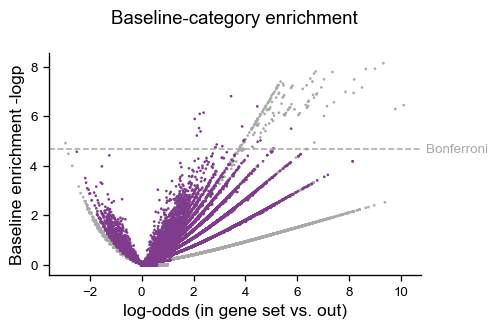

In [83]:
fig, ax = plt.subplots(1, figsize=(5, 3))

nbl_noncoding["x_baseline"] = np.log2(nbl_noncoding["odds_ratio_cases_fisher"])
nbl_noncoding["y_baseline"] = -np.log10(nbl_noncoding["p_cases_fisher"])
nbl_noncoding['hue_baseline'] = np.where(nbl_noncoding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = nbl_noncoding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
data = data[lambda row: ~row['category'].str.contains('cosmic')] 

for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
ax.legend().remove()

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/nbl-noncoding-baseline-category.png", bbox_inches="tight")

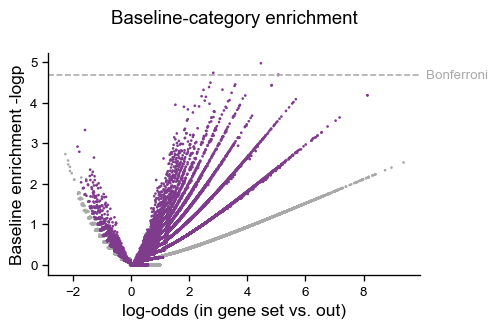

In [84]:
fig, ax = plt.subplots(1, figsize=(5, 3))

nbl_noncoding["x_baseline"] = np.log2(nbl_noncoding["odds_ratio_cases_fisher"])
nbl_noncoding["y_baseline"] = -np.log10(nbl_noncoding["p_cases_fisher"])
nbl_noncoding['hue_baseline'] = np.where(nbl_noncoding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = nbl_noncoding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
data = data[lambda row: ~row['category'].str.contains('cosmic')] 
data = data[lambda row: row['category'].str.contains('SINGLETON')]

for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
ax.legend().remove()

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/nbl-singleton-noncoding-baseline-category.png", bbox_inches="tight")

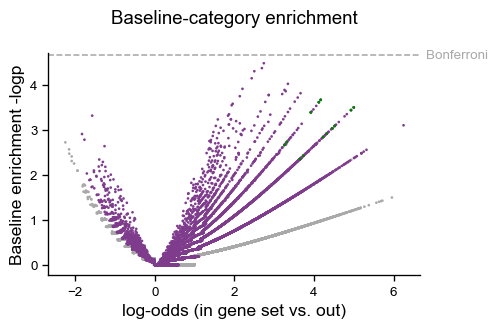

In [85]:
fig, ax = plt.subplots(1, figsize=(5, 3))

nbl_noncoding["x_baseline"] = np.log2(nbl_noncoding["odds_ratio_cases_fisher"])
nbl_noncoding["y_baseline"] = -np.log10(nbl_noncoding["p_cases_fisher"])
nbl_noncoding['hue_baseline'] = np.where(nbl_noncoding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = nbl_noncoding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
data = data[lambda row: ~row['category'].str.contains('cosmic')] 
data = data[lambda row: row['category'].str.contains('SINGLETON')]
data = data[lambda row: row['category'].str.contains('neuroblastoma_tad_boundary')]

for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
    sub = data.query('gs == "vesicle coating (GO:0006901)"')
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        data = sub,
        s=4,
        color = 'green',
        ec=None,
        ax=ax
    )
    
ax.legend().remove()

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/nbl-singleton-noncoding-baseline-category-tads.png", bbox_inches="tight")

In [86]:
data.query('num_unique_genes_in_overlap_cases_fisher > 1').sort_values(by = 'y_baseline', ascending = False).iloc[:20]

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within,x_baseline,y_baseline,hue_baseline
116601,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,MSigDB_Hallmark_2020,mTORC1 Signaling,956/113367,9/184,8,6.674029,0.000032,0.090006,0.075027,7289/892897,12/935,10,1.709172,0.139822,0.390488,323.547802,1/260,1/9,1,28.888889,0.065916,1.0,152.529102,0.018435,0.048913,0.007561,1.000000,17.495698,8,0.018435,0.012834,0.271313,0.820028,627.817316,10,0.018435,0.111111,0.154189,1.0,356.793564,1,199/19092,61/3309,2.129170,0.000005,0.000028,0.386618,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,1,3.811141,1.930223,0.811946,2.738558,4.489147,≥ 2
210951,neuroblastoma,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,MSigDB_Hallmark_2020,mTORC1 Signaling,956/113361,9/190,8,6.453661,0.000042,0.115589,0.096352,7289/892839,12/993,10,1.608118,0.157771,0.411241,365.081823,1/260,1/9,1,28.888889,0.065916,1.0,152.529102,0.018435,0.047368,0.009222,1.000000,21.340401,8,0.018435,0.012085,0.155955,0.689923,360.880175,10,0.018435,0.111111,0.154189,1.0,356.793564,1,199/19092,61/3309,2.129170,0.000005,0.000028,0.355521,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,1,3.919737,1.970757,0.811946,2.690118,4.380504,≥ 2
467405,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,GO_Biological_Process_Full,regulation of translation (GO:0006417),2043/113436,10/115,10,5.655457,0.000049,0.135504,0.112953,16279/893317,22/515,17,2.508219,0.000341,0.009103,0.789175,4/265,0/4,0,10.480000,1.000000,1.0,2314.000000,0.034149,0.086957,0.006193,1.000000,14.330817,10,0.034149,0.042718,0.273726,0.718887,633.401967,17,0.034149,0.000000,1.000000,1.0,2314.000000,0,400/19092,113/3309,1.909015,0.000003,0.000583,0.519762,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,1,2.035573,1.025435,-0.000000,2.499644,4.311467,≥ 2
201005,neuroblastoma,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,GO_Biological_Process_Full,regulation of translation (GO:0006417),2043/113431,10/120,10,5.400465,0.000070,0.129350,0.162174,16279/893272,22/560,17,2.298695,0.001183,0.017558,2.736949,4/265,0/4,0,10.480000,1.000000,1.0,2314.000000,0.034149,0.083333,0.008285,1.000000,19.171679,10,0.034149,0.039286,0.483956,0.874456,1119.874939,17,0.034149,0.000000,1.000000,1.0,2314.000000,0,400/19092,113/3309,1.909015,0.000003,0.000583,0.472905,True,expressed_in_adrenal_gland,neuroblastoma_tad_b

In [87]:
data.query('num_unique_genes_in_overlap_cases_fisher > 1').sort_values(by = 'y_baseline', ascending = False).head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within,x_baseline,y_baseline,hue_baseline
116601,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,MSigDB_Hallmark_2020,mTORC1 Signaling,956/113367,9/184,8,6.674029,0.000032,0.090006,0.075027,7289/892897,12/935,10,1.709172,0.139822,0.390488,323.547802,1/260,1/9,1,28.888889,0.065916,1.0,152.529102,0.018435,0.048913,0.007561,1.0,17.495698,8,0.018435,0.012834,0.271313,0.820028,627.817316,10,0.018435,0.111111,0.154189,1.0,356.793564,1,199/19092,61/3309,2.12917,0.000005,0.000028,0.386618,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,1,3.811141,1.930223,0.811946,2.738558,4.489147,≥ 2
210951,neuroblastoma,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,MSigDB_Hallmark_2020,mTORC1 Signaling,956/113361,9/190,8,6.453661,0.000042,0.115589,0.096352,7289/892839,12/993,10,1.608118,0.157771,0.411241,365.081823,1/260,1/9,1,28.888889,0.065916,1.0,152.529102,0.018435,0.047368,0.009222,1.0,21.340401,8,0.018435,0.012085,0.155955,0.689923,360.880175,10,0.018435,0.111111,0.154189,1.0,356.793564,1,199/19092,61/3309,2.12917,0.000005,0.000028,0.355521,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,1,3.919737,1.970757,0.811946,2.690118,4.380504,≥ 2


In [88]:
mtorc1 = ('ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding', 
          'MSigDB_Hallmark_2020 | mTORC1 Signaling')

collagen = ('DEL.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak_conserved.ANY.ANY.ANY.protein_coding', 
            'GO_Biological_Process_Full | cellular response to ionizing radiation (GO:0071479)')

# wnt2 = ('DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding', 
#         'GO_Biological_Process_Full | regulation of Wnt signaling pathway (GO:0030111)')

# protein_folding = ('DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding', 
#                    'GO_Biological_Process_Full | protein folding (GO:0006457)')

I want to take a mega biased look at just look at dosages in these genes for some large categories.

In [89]:
ref_lookups = {}
for i, gene_group in enumerate(
    [mtorc1]
):
    
    test_cat = gene_group[0]
    related_genes = sorted(set(gene_sets[gene_group[1]]))

    test_cat_svs = category_svs[
        (category_svs["category"] == test_cat)
        & (category_svs["disease"] == "neuroblastoma")
    ]["SV"].tolist()

    # get case counts
    case_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "noncoding" & cohort == "case" & dose > 0'
    )
    case_counts = case_counts[(case_counts["name"].isin(test_cat_svs))]

    case_dosage = case_counts["dose"].sum()
    case_gs = case_counts[case_counts["gene"].isin(related_genes)]
    case_gs_dosage = case_gs['dose'].sum()
    
    ref_lookups[gene_group[1]] = case_gs

    # get control coutns
    control_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "noncoding" & cohort == "control" & dose > 0'
    )
    control_counts = control_counts[(control_counts["name"].isin(test_cat_svs))]

    control_dosage = control_counts["dose"].sum()
    control_gs = control_counts[control_counts["gene"].isin(related_genes)]
    control_gs_dosage = control_gs["dose"].sum()
    
    cat_genes = category_gene_matrix.loc[test_cat]
    cat_genes = list(cat_genes[cat_genes == 1].index)
    
    print(gene_group[0])
    print(gene_group[1])
    print(case_gs_dosage, case_dosage, control_gs_dosage, control_dosage, len(set(cat_genes) & set(related_genes)), len(cat_genes))
    print(case_gs_dosage / case_dosage, control_gs_dosage / control_dosage, len(set(cat_genes) & set(related_genes)) / len(cat_genes))
    
    print(case_gs['gene'].tolist(), control_gs['gene'].tolist())
    print()


ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding
MSigDB_Hallmark_2020 | mTORC1 Signaling
9 184 12 943 61 3309
0.04891304347826087 0.012725344644750796 0.018434572378362043
['ENO1', 'ENO1', 'SLC1A4', 'SERP1', 'SSR1', 'TES', 'PSMA4', 'RPA1', 'XBP1'] ['ENO1', 'ENO1', 'SLC1A4', 'SLC1A4', 'SERP1', 'ELOVL6', 'GLRX', 'GCLC', 'YKT6', 'CYP51A1', 'NUP205', 'RPA1']



In [90]:
for thing in case_gs['gene']:
    print(thing, end = ', ')

ENO1, ENO1, SLC1A4, SERP1, SSR1, TES, PSMA4, RPA1, XBP1, 

In [91]:
test_tad_svs = case_gs[~case_gs['gene'].isin(control_gs['gene'].tolist())]
test_tad_svs

,name,dose,gene,disease,sv_category,cohort
84413,PedSV.2.5.2_DEL_chr6_599,1,SSR1,neuroblastoma,noncoding,case
102032,PedSV.2.5.2_DEL_chr7_9454,1,TES,neuroblastoma,noncoding,case
161708,PedSV.2.5.2_INS_chr15_1766,1,PSMA4,neuroblastoma,noncoding,case
192769,PedSV.2.5.2_DEL_chr22_1485,1,XBP1,neuroblastoma,noncoding,case


In [92]:
svs[svs['name'].isin(test_tad_svs['name'].tolist())]

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR
79631,chr6,7274000,7280001,PedSV.2.5.2_DEL_chr6_599,DEL,1,0.000077,depth,13028,False,NaN,NaN,NaN,NaN,7280001,NaN,RD,NaN,1.0,1.0,1.0,False,False,NaN,NaN,-12.0,51,0.029754,NaN,1.0,All_20_Batches.chr6.final_cleanup_DEL_chr6_671,0.005134,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,SSR1,"ewing_chromHMM15_Quies,neuroblastoma_tad_boundary,osteosarcoma_chromHMM15_Quies","ewing_and_osteosarcoma_atac_peaks,ewing_and_osteosarcoma_atac_peaks_unconserved,neuroblastoma_atac_peaks,neuroblastoma_atac_peaks_unconserved,neuroblastoma_chromHMM15_Enh_unconserved",NaN,NaN,NaN,NaN
102321,chr7,116240378,116241579,PedSV.2.5.2_DEL_chr7_9454,DEL,1,0.000074,manta,13462,True,NaN,NaN,NaN,NaN,116241579,NaN,"PE,SR",NaN,1.0,1.0,1.0,False,False,NaN,NaN,-12.0,0,0.000000,NaN,1.0,All_20_Batches.chr7.final_cleanup_DEL_chr7_11060,0.000000,False,NaN,NaN,NaN,False,NaN,TES,NaN,NaN,NaN,NaN,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM15_Quies,neuroblastoma_tad_boundary",NaN,NaN,NaN,NaN,NaN
178058,chr15,78552116,78552117,PedSV.2.5.2_INS_chr15_1766,INS:ME:ALU,1,0.000074,melt,13458,False,NaN,NaN,NaN,NaN,78552117,NaN,SR,NaN,1.0,0.5,1.0,False,False,NaN,NaN,-97.0,2,0.000213,NaN,0.5,All_20_Batches.chr15.final_cleanup_INS_chr15_2028,0.000201,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,neuroblastoma_tad_boundary,NaN,NaN,NaN,NaN,PSMA4
217932,chr22,28830246,28832587,PedSV.2.5.2_DEL_chr22_1485,DEL,1,0.000074,manta,13462,True,NaN,NaN,NaN,NaN,28832587,NaN,"PE,SR",NaN,1.0,1.0,1.0,False,False,NaN,NaN,-12.0,0,0.000000,NaN,1.0,All_20_Batches.chr22.final_cleanup_DEL_chr22_1804,0.000000,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,XBP1,"ewing_chromHMM15_Quies,neuroblastoma_H3K27Ac_peak_unconserved,neuroblastoma_chromHMM15_Enh_unconserved,neuroblastoma_tad_boundary,osteosarcoma_chromHMM15_Quies","ewing_and_osteosarcoma_atac_peaks_unconserved,neuroblastoma_atac_peaks_unconserved",NaN,NaN,NaN,NaN


In [93]:
intergenic_sv_to_gene_distances.query('name == "PedSV.2.5.2_DEL_chr22_1485"')

,name,#chrom,start_sv,end_sv,gene_name,start_gene,end_gene,distance
128951,PedSV.2.5.2_DEL_chr22_1485,chr22,28830246,28832587,XBP1,28794555,28800597,29649


In [94]:
nbl_noncoding.query('category == "DUP.RARE.PREDICTED_NONCODING_SPAN.neuroblastoma_H3K27Ac_peak_conserved.PREDICTED_INTRONIC.lof_constrained.expressed_in_adrenal_gland.protein_coding" & gs == "collagen metabolic process (GO:0032963)"')

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within,x_baseline,y_baseline,hue_baseline
765727,neuroblastoma,DUP.RARE.PREDICTED_NONCODING_SPAN.neuroblastoma_H3K27Ac_peak_conserved.PREDICTED_INTRONIC.lof_constrained.expressed_in_adrenal_gland.protein_coding,noncoding,full,GO_Biological_Process_Full,collagen metabolic process (GO:0032963),310/113542,6/9,1,637.163183,7.333706e-09,0.00002,0.000017,2531/893816,0/16,0,20.706393,1.0,1.0,2313.999993,0/269,0/0,0,270.0,1.0,1.0,2314.0,0.006183,0.666667,4.620159e-12,6.412781e-09,1.069105e-08,1,0.006183,0.0,1.0,1.0,2314.0,0,0.006183,NaN,NaN,NaN,NaN,0,62/19092,11/1779,2.105869,0.043883,0.226917,1.547282,False,expressed_in_adrenal_gland,neuroblastoma_H3K27Ac_peak_conserved,1,inf,inf,NaN,9.315519,8.134677,1


In [95]:
dosages.loc['PedSV.2.5.2_DUP_chr5_3135', samples['neuroblastoma']['case']].sum(), dosages.loc['PedSV.2.5.2_DUP_chr5_3135', samples['neuroblastoma']['control']].sum()

(6.0, 0.0)

## Ewing coding

In [96]:
ewing_coding = combined_gse_results.query(
    'disease == "ewing" & sv_category == "coding" & analysis_fisher == "full"'
)
ewing_coding = ewing_coding.query("p_controls_binom > 0.05")

ewing_coding['hue_within'] = np.where(ewing_coding['num_unique_genes_in_overlap_cases_unique_binom'] > 1, '≥ 2', '1')
palette = {'≥ 2': Bold_10[0], '1': 'darkgrey'}

ewing_coding["binom_odds_ratio"] = (
    ewing_coding["observed_prop_cases_binom"] / ewing_coding["observed_prop_controls_binom"]
)

ewing_coding["x_within"] = np.log2(ewing_coding["binom_odds_ratio"])
ewing_coding["y_within"] = -np.log10(ewing_coding["p_cases_unique_binom"])

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Within-category

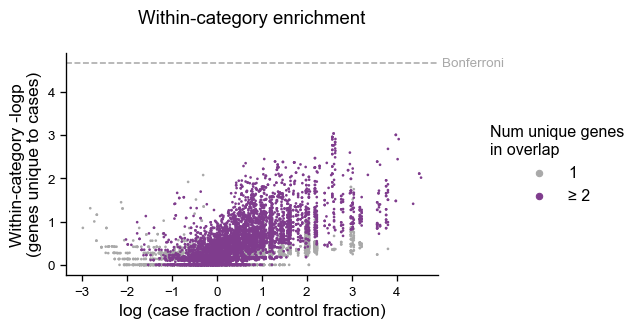

In [97]:
fig, ax = plt.subplots(1, figsize=(5, 3))

data = ewing_coding.query('num_unique_genes_in_overlap_cases_unique_binom > 0')
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_within',
        y='y_within',
        hue = 'hue_within',
        data = data[data['hue_within'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )

ax.legend(bbox_to_anchor = (1.1, 0.5), title = 'Num unique genes\nin overlap', title_fontsize = 12)

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
sns.despine(ax=ax)
ax.set_xlabel("log (case fraction / control fraction)")
ax.set_ylabel("Within-category -logp\n(genes unique to cases)")
ax.set_title("Within-category enrichment", y=1.1)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)

fig.savefig("images/ewing-coding-within-category.png", bbox_inches="tight")

In [98]:
ewing_coding.sort_values(by="y_within", ascending = False) \
[['category', 'gs', 'num_unique_genes_in_overlap_cases_fisher', 'y_within', 'x_within']].head(5)

,category,gs,num_unique_genes_in_overlap_cases_fisher,y_within,x_within
97005,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,head morphogenesis (GO:0060323),3,3.039565,2.596987
19305,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,head morphogenesis (GO:0060323),3,3.039565,2.596987
504251,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,platelet activation (GO:0030168),4,3.007638,3.982859
498701,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,platelet activation (GO:0030168),4,3.007638,3.982859
501723,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,coagulation (GO:0050817),6,2.957379,2.567821


In [99]:
sensory = ('ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 
          'GO_Biological_Process_Full | detection of mechanical stimulus involved in sensory perception (GO:0050974)')

cations = ('DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding', 
            'GO_Biological_Process_Full | inorganic cation transmembrane transport (GO:0098662)')

# wnt2 = ('DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding', 
#         'GO_Biological_Process_Full | regulation of Wnt signaling pathway (GO:0030111)')

# protein_folding = ('DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding', 
#                    'GO_Biological_Process_Full | protein folding (GO:0006457)')

I want to take a mega biased look at just look at dosages in these genes for some large categories.

In [100]:
ref_lookups = {}
for i, gene_group in enumerate(
    [sensory, cations]
):
    
    test_cat = gene_group[0]
    related_genes = sorted(set(gene_sets[gene_group[1]]))

    test_cat_svs = category_svs[
        (category_svs["category"] == test_cat)
        & (category_svs["disease"] == "ewing")
    ]["SV"].tolist()

    # get case counts
    case_counts = ref_counts.query(
        'disease == "ewing" & sv_category == "coding" & cohort == "case" & dose > 0'
    )
    case_counts = case_counts[(case_counts["name"].isin(test_cat_svs))]

    case_dosage = case_counts["dose"].sum()
    case_gs = case_counts[case_counts["gene"].isin(related_genes)]
    case_gs_dosage = case_gs['dose'].sum()
    
    ref_lookups[gene_group[1]] = case_gs

    # get control coutns
    control_counts = ref_counts.query(
        'disease == "ewing" & sv_category == "coding" & cohort == "control" & dose > 0'
    )
    control_counts = control_counts[(control_counts["name"].isin(test_cat_svs))]

    control_dosage = control_counts["dose"].sum()
    control_gs = control_counts[control_counts["gene"].isin(related_genes)]
    control_gs_dosage = control_gs["dose"].sum()
    
    cat_genes = category_gene_matrix.loc[test_cat]
    cat_genes = list(cat_genes[cat_genes == 1].index)
    
    print(gene_group[0])
    print(gene_group[1])
    print(case_gs_dosage, case_dosage, control_gs_dosage, control_dosage, len(set(cat_genes) & set(related_genes)), len(cat_genes))
    print(case_gs_dosage / case_dosage, control_gs_dosage / control_dosage, len(set(cat_genes) & set(related_genes)) / len(cat_genes))
    
    print(case_gs['gene'].tolist(), control_gs['gene'].tolist())
    print()


ANY.SINGLETON.ANY.ANY.ANY.protein_coding
GO_Biological_Process_Full | detection of mechanical stimulus involved in sensory perception (GO:0050974)
7 800 3 3638 35 19092
0.00875 0.0008246289169873557 0.0018332285774146238
['SCN11A', 'ADGRV1', 'ADGRV1', 'TMC1', 'CXCL12', 'CHRNA10', 'CHRNA10'] ['PIEZO2', 'PIEZO2', 'MKKS']

DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding
GO_Biological_Process_Full | inorganic cation transmembrane transport (GO:0098662)
31 541 60 2347 653 19092
0.05730129390018484 0.02556455048998722 0.03420280745862141
['SLC9A1', 'ATP5PB', 'SLC30A10', 'SLC4A7', 'SCN11A', 'CACNA2D3', 'CACNA2D3', 'SLC12A8', 'SLC9B1', 'UCP1', 'SLC25A4', 'ITPR3', 'KCNV2', 'SLC1A1', 'TMC1', 'TMEM38B', 'GRIN1', 'GHITM', 'PKD2L1', 'PKD2L1', 'CHRNA10', 'GRIK4', 'SLC4A8', 'TRPV4', 'ATP7B', 'SLC28A1', 'AQP8', 'PKD1L3', 'TRPV3', 'TRPM4', 'LARGE1'] ['RHCE', 'RHCE', 'CACHD1', 'KCNT2', 'ATP6V1C2', 'SLC4A10', 'SCN7A', 'ATP2B2', 'SCN10A', 'CACNA2D3', 'HTR3C', 'TMEM175', 'K

### Baseline enrichment

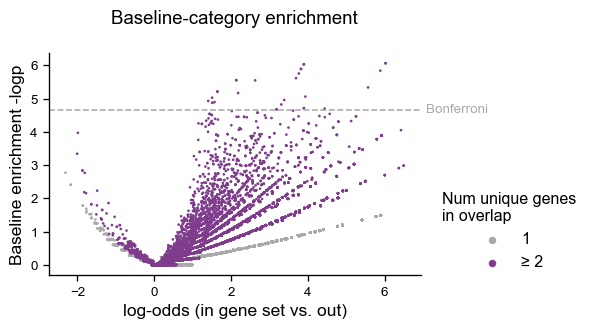

In [101]:
fig, ax = plt.subplots(1, figsize=(5, 3))

ewing_coding["x_baseline"] = np.log2(ewing_coding["odds_ratio_cases_fisher"])
ewing_coding["y_baseline"] = -np.log10(ewing_coding["p_cases_fisher"])
ewing_coding['hue_baseline'] = np.where(ewing_coding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = ewing_coding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
ax.legend(bbox_to_anchor = (1.02, 0.2), title = 'Num unique genes\nin overlap', title_fontsize = 12)

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/ewing-coding-baseline-category.png", bbox_inches="tight")

What are the categories that have synaptic transmission signal?

In [104]:
framework_results.query('disease == "ewing" & sv_category == "coding" & bonferroni_significant')

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,disease,sv_category,af_category,bonferroni_p,bonferroni_significant
83,0.332677,0.086960,3.825642,0.000130,176,3,595,751,726,3,3786,4449,1249,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,ANY,SINGLETON,0.234354,0.163183,0.173462,3.884617,ewing,coding,singleton,0.034825,True
84,0.197631,0.050307,3.928520,0.000085,488,4,398,751,2270,5,2737,4449,3833,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,ANY,SINGLETON,0.649800,0.510227,0.530385,4.068185,ewing,coding,singleton,0.022821,True
85,0.315374,0.073375,4.298137,0.000017,242,4,551,751,1002,4,3561,4449,1712,ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,ANY,SINGLETON,0.322237,0.225219,0.239231,4.763867,ewing,coding,singleton,0.004599,True
86,0.198498,0.044648,4.445881,0.000009,617,5,340,751,2881,5,2416,4449,4853,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,ANY,SINGLETON,0.821571,0.647561,0.672692,5.057831,ewing,coding,singleton,0.002337,True
87,0.384427,0.091048,4.222271,0.000024,163,3,605,751,639,3,3861,4449,1102,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,DEL,SINGLETON,0.217044,0.143628,0.154231,4.616448,ewing,coding,singleton,0.006457,True
88,0.224395,0.052646,4.262362,0.000020,449,4,414,751,2030,5,2882,4449,3436,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,DEL,SINGLETON,0.597870,0.456282,0.476731,4.694053,ewing,coding,singleton,0.005401,True
89,0.384427,0.091048,4.222271,0.000024,163,3,605,751,639,3,3861,4449,1102,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,DEL,SINGLETON,0.217044,0.143628,0.154231,4.616448,ewing,coding,singleton,0.006457,True
90,0.224395,0.052646,4.262362,0.000020,449,4,414,751,2030,5,2882,4449,3436,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.597870,0.456282,0.476731,4.694053,ewing,coding,singleton,0.005401,True


In [108]:
ewing_coding.query('category == "ANY.SINGLETON.ANY.ANY.ANY.protein_coding"').sort_values(by="y_baseline", ascending = False).query('x_baseline > 0')[['category', 'gs', 'y_baseline']].head(20)

,category,gs,y_baseline
76535,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,monoatomic cation homeostasis (GO:0055080),5.551896
74707,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,monoatomic ion homeostasis (GO:0050801),5.551896
74047,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,positive regulation of synaptic transmission (GO:0050806),5.335742
74023,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,regulation of protein depolymerization (GO:1901879),5.059742
72887,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,metal ion transport (GO:0030001),5.025967
77579,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,monoatomic cation transport (GO:0006812),4.929434
75579,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,regulation of protein-containing complex disassembly (GO:0043244),4.634760
72737,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,regulation of B cell activation (GO:0050864),4.541222
75931,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,central nervous system development (GO:0007417),4.538909
76489,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,developmental growth (GO:0048589),4.453929


In [102]:
ewing_coding.sort_values(by="y_baseline", ascending = False).query('x_baseline > 0').head(20)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within,x_baseline,y_baseline,hue_baseline
18547,ewing,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,full,GO_Biological_Process_Full,positive regulation of synaptic transmission (GO:0050806),0/3535,6/385,6,65.136842,8.663809e-07,0.002405,0.002005,14/20933,7/1747,7,6.408577,0.000705,0.006144,1.630277,0/425,4/217,4,9.953271,0.012814,1.000000,29.652081,0.007333,0.015584,0.066438,1.000000,153.737803,6,0.007333,0.004007,0.120826,0.589477,279.590710,7,0.007333,0.018433,0.076901,1.00000,177.948488,4,140/19092,140/19092,NaN,1.000000,1.000000,0.224395,True,ANY,NaN,≥ 2,3.889425,1.959557,1.114069,6.025402,6.062291,≥ 2
96247,ewing,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,coding,full,GO_Biological_Process_Full,positive regulation of synaptic transmission (GO:0050806),0/3535,6/385,6,65.136842,8.663809e-07,0.002405,0.002005,14/20933,7/1747,7,6.408577,0.000705,0.006144,1.630277,0/425,4/217,4,9.953271,0.012814,1.000000,29.652081,0.007333,0.015584,0.066438,1.000000,153.737803,6,0.007333,0.004007,0.120826,0.589477,279.590710,7,0.007333,0.018433,0.076901,1.00000,177.948488,4,140/19092,140/19092,NaN,1.000000,1.000000,0.224395,True,ANY,NaN,≥ 2,3.889425,1.959557,1.114069,6.025402,6.062291,≥ 2
499523,ewing,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,coding,full,MSigDB_Hallmark_2020,Adipogenesis,18/3793,8/127,8,14.905263,9.316712e-07,0.001788,0.002156,147/22178,11/502,11,3.630850,0.000812,0.010494,1.878944,5/562,5/80,5,7.342105,0.004048,0.623400,9.367518,0.021940,0.062992,0.007185,1.000000,16.625730,8,0.021940,0.021912,1.000000,1.000000,2314.000000,11,0.021940,0.062500,0.031563,1.00000,73.035927,5,200/19092,166/7566,7.582162,0.000003,0.000007,0.384427,True,expressed_in_muscle_skeletal,NaN,≥ 2,2.874732,1.523427,1.500827,3.897750,6.030737,≥ 2
493973,ewing,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,coding,full,MSigDB_Hallmark_2020,Adipogenesis,18/3793,8/127,8,14.905263,9.316712e-07,0.001788,0.002156,147/22178,11/502,11,3.630850,0.000812,0.010494,1.878944,5/562,5/80,5,7.342105,0.004048,0.623400,9.367518,0.021940,0.062992,0.007185,1.000000,16.625730,8,0.021940,0.021912,1.000000,1.000000,2314.000000,11,0.021940,0.062500,0.031563,1.00000,73.035927,5,200/19092,166/7566,7.582162,0.000003,0.000007,0.384427,True,expressed_in_muscle_skeletal,NaN,≥ 2,2.874732,1.523427,1.500827,3.897750,6.030737,≥ 2
499563,ewing,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,coding,full,MSigDB_Hallmark_2020,Xenobiotic Metabolism,19/3793,8/127,7,14.156250,1.288242e-06,0.001788,0.002981,207/22178,7/502,7,1.703784,0.245476,0.507402,568.030498,2/562,5/80

In [104]:
adipo = ('DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 
          'MSigDB_Hallmark_2020 | Adipogenesis')

energy = ('ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 
           'GO_Biological_Process_Full | generation of precursor metabolites and energy (GO:0006091)')

xenobiotic_met = ('DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding',
                  'MSigDB_Hallmark_2020 | Xenobiotic Metabolism')

# wnt2 = ('DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding', 
#         'GO_Biological_Process_Full | regulation of Wnt signaling pathway (GO:0030111)')

# protein_folding = ('DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding', 
#                    'GO_Biological_Process_Full | protein folding (GO:0006457)')

In [105]:
ref_lookups = {}
for i, gene_group in enumerate(
    [adipo, energy, xenobiotic_met]
):
    
    test_cat = gene_group[0]
    related_genes = sorted(set(gene_sets[gene_group[1]]))

    test_cat_svs = category_svs[
        (category_svs["category"] == test_cat)
        & (category_svs["disease"] == "ewing")
    ]["SV"].tolist()

    # get case counts
    case_counts = ref_counts.query(
        'disease == "ewing" & sv_category == "coding" & cohort == "case" & dose > 0'
    )
    case_counts = case_counts[(case_counts["name"].isin(test_cat_svs))]

    case_dosage = case_counts["dose"].sum()
    case_gs = case_counts[case_counts["gene"].isin(related_genes)]
    case_gs_dosage = case_gs['dose'].sum()
    
    ref_lookups[gene_group[1]] = case_gs

    # get control coutns
    control_counts = ref_counts.query(
        'disease == "ewing" & sv_category == "coding" & cohort == "control" & dose > 0'
    )
    control_counts = control_counts[(control_counts["name"].isin(test_cat_svs))]

    control_dosage = control_counts["dose"].sum()
    control_gs = control_counts[control_counts["gene"].isin(related_genes)]
    control_gs_dosage = control_gs["dose"].sum()
    
    cat_genes = category_gene_matrix.loc[test_cat]
    cat_genes = list(cat_genes[cat_genes == 1].index)
    
    print(gene_group[0])
    print(gene_group[1])
    print(case_gs_dosage, case_dosage, control_gs_dosage, control_dosage, len(set(cat_genes) & set(related_genes)), len(cat_genes))
    print(case_gs_dosage / case_dosage, control_gs_dosage / control_dosage, len(set(cat_genes) & set(related_genes)) / len(cat_genes))
    
    print(case_gs['gene'].tolist(), control_gs['gene'].tolist())
    print()


DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding
MSigDB_Hallmark_2020 | Adipogenesis
9 208 15 802 166 7566
0.04326923076923077 0.018703241895261846 0.021940259053661114
['ELMOD3', 'REEP5', 'CD36', 'GHITM', 'SNCG', 'CHUK', 'DHRS7', 'ACOX1', 'SAMM50'] ['AK2', 'HIBCH', 'MCCC1', 'ADIPOQ', 'ME1', 'CD36', 'FABP4', 'ITIH5', 'VEGFB', 'SSPN', 'ALDOA', 'PEMT', 'LIPE', 'BCL2L13', 'TST']

ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding
GO_Biological_Process_Full | generation of precursor metabolites and energy (GO:0006091)
17 351 35 1469 258 7566
0.04843304843304843 0.023825731790333562 0.03409992069785884
['NDUFS5', 'ATP5PB', 'DGUOK', 'PER2', 'SUCLG2', 'SLC25A4', 'LYRM7', 'SLC25A13', 'GSR', 'ASPH', 'ASPH', 'FXN', 'PFKP', 'NDUFC2', 'PHKB', 'ACOX1', 'ME2'] ['ALDH4A1', 'AKR7A3', 'POMC', 'GFPT1', 'DGUOK', 'GYG1', 'ADIPOQ', 'NDUFC1', 'ETFDH', 'SDHA', 'ME1', 'OGDH', 'FXN', 'PFKP', 'DHTKD1', 'NDUFV1', 'DERA', 'DNAJC15', 'DNAJC15', 'DNAJC15', 'OXA1L', 'PYGL', 'ETFA', 'W